In [2]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re


PCA_color_ref= ['darkseagreen','crimson', 'darkorange', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink']

%matplotlib inline

## .vcf analysis

Jupyter notebook for the local analysis of genetic data stored in `.vcf` format.

Perform analysis of structure across data set, followed by a more detailed study of variation across local genomic windows.

## Input

In [3]:
from structure_tools.vcf_geno_tools import simple_read_vcf

vcf_file= 'data_val_g30d0.40s10.vcf'

genotype, summary, info_save= simple_read_vcf(vcf_file,row_info= 5,header_info= 9,phased= False)

print('Number of markers: {}'.format(genotype.shape[1]))
print('Number of individuals: {}'.format(genotype.shape[0]))



Number of markers: 18881
Number of individuals: 110


In [4]:
from structure_tools.Tutorial_subplots import plot_global_pca

## Perform PCA
n_comp= 3

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')

feats= pca.fit_transform(genotype)
## perform MeanShift clustering.
bandwidth = estimate_bandwidth(feats, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=25)
ms.fit(feats)
labels1 = ms.labels_
label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}

###
plot_global_pca(feats,label_select,PCA_color_ref,title= 'global_pca',height= 500,width= 950)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Local Analysis

Analyse genetic variation across genomic windows. Begin by chosing the size of each window (`window_size`) and the distance between windows (in number of markers, `Steps`).

In [5]:
from structure_tools.vcf_geno_tools import geno_window_split
##### 
window_size= 150
Steps= 20

Windows, Out= geno_window_split(genotype,
                                summary,
                                Steps= Steps,
                                window_size=window_size)

print('number of chromosomes: {}'.format(len(Windows)))
print('number of windows: {}'.format(sum([len(Windows[x].keys()) for x in Windows.keys()])))


number of chromosomes: 1
number of windows: 938


###  Variation across windows


Chose:

- a range of windows; 
- populations; 
- principal components to keep.

Perform PCA at each window. For each population, centre samples from that pop by PC. Extract coordinates for the PC selected.

Calculate the confidence interval of the selected samples across data sets (mean is now 0). Extract the distance between upper and lower bounds. 


In [6]:
from structure_tools.vcf_geno_tools import window_analysis

dict_coords= {}
Windows_range_pca= [100,350]
ref_labels= [2,3,4]

group_list= [2,2]
PC_selection= [1,2]

for access in range(len(group_list)):
    include_who= [group_list[access]]
    

    Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                     ref_labels,
                                                                                     labels1,
                                                                                     Chr= 1,
                                                                                     ncomp= 4,
                                                                                     amova= False,
                                                                                     supervised= True,
                                                                                     include_who= include_who,
                                                                                     range_sample= Windows_range_pca,
                                                                                     rand_sample= 0,
                                                                                     clsize= 15,
                                                                                     cl_freqs= 5,
                                                                                     Bandwidth_split= 20,
                                                                                     quantile= .2,
                                                                                     centre_d= True,
                                                                                     PC_sel= PC_selection[access] - 1)
    
    labels_code_s= labels1

    if include_who:
        labels_code_s= [x for x in labels_code_s if x in include_who]
    
    dict_coords[access]= {
        'coords': pc_coords_s,
        'dens': pc_density_s,
        'labs': labels_code_s
    }



In [23]:
from structure_tools.Tutorial_subplots import PC_analysis_plot

for access in range(len(group_list)):
    include_who= [group_list[access]]
    

    fig= PC_analysis_plot(dict_coords[access]['dens'],dict_coords[access]['coords'],dict_coords[access]['labs'],PCA_color_ref,range_windows= Windows_range_pca,
                     plot_choice= 'coords',height= 400,width= 1000,y_range= [-9,12],qtl= .99,PC_sel= PC_selection[access])
    
    iplot(fig)


250
(250, 2)


250
(250, 2)


## Sound from amp

We will use the standard deviation of a single population across a given component as the amplitude of a audio signal.

First select the group, PC and range of local windows to use. We run the `window_analysis` function to extract centred PCA coordinates. Then use each data set as frames and the boundary distance as amplitude. To produce sound select a frequency, a total length in seconds and a sample rate. Amplitude is interpolated for the extra frames necessary to make the range of windows selected above to fit `length / sample rate`.

### A single sample. PC var as amplitude.

In [7]:
from music_tools.my_music_tools import get_sound_coords
import music_tools.thinkdsp as thinkdsp
import music_tools.thinkplot as thinkplot

qtl= 0.95

group= 2
PC_select= 1

sampleRate = 44100
frequency = 1800
length = 10


fig_test, wave_s= get_sound_coords(dict_coords[0]['coords'],
                               sampleRate= sampleRate,
                                    frequency= frequency,
                                length= length,
                                group= group,
                                PC_select= PC_select)


fig_test['layout'].update(height= 400,width= 900)
iplot(fig_test)

In [8]:
wave_s.make_audio()

### Multiple tracks.

The truth is that a sound signal is more complicated than a single sin waved capped by amplitude boundaries. 

Multiple frequencies go into making most sounds. What we hear is the concatenation of those signals on different amplitudes (litterally the sum of the different sin waves). It is thus quite synthetic to want a more concrete sound out of genetic data if it only gives us the amplitude. 

But we can try. 

The idea in this section is to use the amplitude idea above, only apply it to more than one track and at different frequencies to simulate a given song. 

**Disclaimer** this really only works with very clean sound. 

**Disclaimer II** much core code below was compied from Allen Downey's github ([thinkDSP](https://github.com/AllenDowney/ThinkDSP)) as were the sound samples (sax and violin) used for testing and development.  

We will begin by reading a sound file. in this case one of the .wav samples provided by AD. We will use the librosa library to read the file into its collection of amp by frame and sample rate components.

Then we will use the fourrier transform to transform the wave into its component frequencies. 
I have left the choice of library (librosa or thinkdsp) to the user. The output is a bit different i dont know why yet i think librosa does some processing of the fourrier output.

In [9]:

from __future__ import print_function
import librosa

# 1. Get the file path to the included audio example
filename = '92002__jcveliz__violin-origional.wav'
filename = '100475__iluppai__saxophone-weep.wav'
#filename = '105977__wcfl10__favorite-station.wav'
#filename = 'harry_potter_theme.mp3'
#filename= 'imperialmarch.mp3'

# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y_wav, sr = librosa.load(filename)

wave_violin= thinkdsp.Wave(y_wav,framerate=sr)

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y_wav, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

print('Saving output to beat_times.csv')
librosa.output.times_csv('beat_times.csv', beat_times)

Estimated tempo: 103.36 beats per minute
Saving output to beat_times.csv


In [10]:
keep= 10
plus= 0
#y_keep= y_wav[(plus*sr):(plus*sr+keep * sr)]
y_keep= y_wav

In [11]:
wave_vio= thinkdsp.Wave(y_keep,framerate=sr)

wave_vio.make_audio()

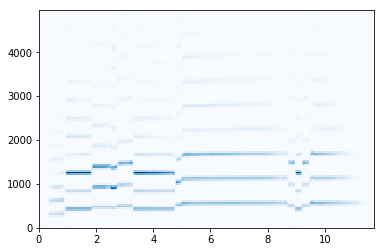

In [12]:
seg_length= 512

height= 5000
spectrogram = wave_vio.make_spectrogram(seg_length= seg_length)
spectrogram.plot(high=height)

In [13]:
from music_tools.my_music_tools import find_index, return_spec_array

method_list= ['tdsp','librosa']
method_pick= 0

method= method_list[method_pick]

### using librosa

if method == 'librosa':
    
    step = int(seg_length // 2)
    n_mels= 128

    array_spec = librosa.feature.melspectrogram(y=y, hop_length=step,
                                                    fmax=height, n_fft= seg_length, sr= sr, n_mels= n_mels)

    spec_fs= np.linspace(0,height,n_mels,seg_length)
    spec_ts= np.arange(0,len(y),step)
    spec_ts= (spec_ts / len(y)) * (len(y) /sr)

if method == 'tdsp':
    
    array_spec, spec_ts, spec_fs= return_spec_array(spectrogram,high= height)
    array_spec.shape


In [14]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs
from music_tools.my_music_tools import plot_frame, cluster_threshold, frame_peaks


In [15]:

frame_plot= 50
plot_frame(array_spec,frame_plot,spec_fs,height= 300,width= 900)

In [16]:
array_spec.shape

(116, 1010)

In [17]:

frame= 134
Sample_N= 500
p_threshold= 0.0004
amp_cap= 5
peak_cap= 2
peak_iso= 200
band_qtl= 0.02
frame_plot= True


peak_cent, time_spec, amps_centres, figure_frame= frame_peaks(array_spec, spec_fs, spec_ts,
                frame= frame,
                Sample_N= Sample_N,
                p_threshold= p_threshold,
                amp_cap= amp_cap,
                peak_cap= peak_cap,
                peak_iso= peak_iso,
                band_qtl= band_qtl,
                frame_plot= frame_plot)



#
iplot(figure_frame)


In [18]:
##########
##########
frame_many= array_spec.shape[1]
frame_crawl= np.linspace(0,array_spec.shape[1] - 1,frame_many)

ts_list= []
peaks= []
amps= []

Sample_N= 1000
p_threshold= 0.0004
amp_cap= 6
peak_cap= 1.2
peak_iso= 250
band_qtl= 0.11
frame_plot= False


for frame in range(array_spec.shape[1]):

    
    peak_cent, time_spec, amps_centres= frame_peaks(array_spec, spec_fs, spec_ts,
                    frame,
                    Sample_N= Sample_N,
                    p_threshold= p_threshold,
                    amp_cap= amp_cap,
                    peak_cap= peak_cap,
                    peak_iso= peak_iso,
                    band_qtl= band_qtl,
                    frame_plot= frame_plot)
    
    peaks.extend(peak_cent)
    ts_list.extend([spec_ts[frame]]* len(amps_centres))
    amps.extend(amps_centres)


samps_tracks= np.array([
    ts_list,
    peaks,
    amps
]).T


In [19]:
from music_tools.my_music_tools import filter_output

output_peak_filter= filter_output(samps_tracks)
iplot(output_peak_filter)


In [20]:
## from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from plotly import tools


In [21]:
from music_tools.my_music_tools import break_down_spec
from plotly import tools

N_neigh= 0
ms_layer2= True
scale_spec= False
qtl_I= 0.05
qtl_II= 0.1
clst_all_I= True
clst_all_II= True

coords, figures_ms, plot_names= break_down_spec(samps_tracks,N_neigh= N_neigh,
                                    ms_layer2= ms_layer2,
                                    scale_spec= scale_spec,
                                       qtl_I= qtl_I,
                                       qtl_II= qtl_II,
                                       clst_all_I= clst_all_I,
                                       clst_all_II= clst_all_II)



titles= plot_names
Ncols= 1
print(titles)

fig_subplots = tools.make_subplots(rows= len(titles), cols=Ncols,
                         subplot_titles=tuple(titles))

for gp in range(len(titles)):

    pos1= gp + 1
    pos2= 1

    title= titles[gp]


    fig= figures_ms[gp]
    
    for trace1 in fig['data']:

        fig_subplots.append_trace(trace1, pos1, pos2)


    fig_subplots['layout']['yaxis' + str(gp + 1)].update(title=fig['layout']['yaxis']['title'])

    fig_subplots['layout']['xaxis' + str(gp + 1)].update(title=fig['layout']['xaxis']['title'])



fig_subplots['layout'].update(height= 700,width= 900)
iplot(fig_subplots)


['MS1', 'MSII']
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [22]:
from music_tools.my_music_tools import meanfreq_plot

mean_plot= meanfreq_plot(samps_tracks,coords,ts_list,peaks,height= 500,width= 900)
iplot(mean_plot)

In [36]:
#######
#######

from structure_tools.vcf_geno_tools import window_analysis

dict_coords= {}
Windows_range_pca= [0,350]
ref_labels= [2,3,4]

group_list= [2,3,4,2]
PC_selection= [1,1,1,2]

for access in range(len(group_list)):
    include_who= [group_list[access]]
    

    Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                     ref_labels,
                                                                                     labels1,
                                                                                     Chr= 1,
                                                                                     ncomp= 4,
                                                                                     amova= False,
                                                                                     supervised= True,
                                                                                     include_who= include_who,
                                                                                     range_sample= Windows_range_pca,
                                                                                     rand_sample= 0,
                                                                                     clsize= 15,
                                                                                     cl_freqs= 5,
                                                                                     Bandwidth_split= 20,
                                                                                     quantile= .2,
                                                                                     centre_d= True,
                                                                                     PC_sel= PC_selection[access] - 1)
    
    
    labels_code_s= labels1

    if include_who:
        labels_code_s= [x for x in labels_code_s if x in include_who]
    
    dict_coords[access]= {
        'coords': pc_coords_s,
        'dens': pc_density_s,
        'labs': labels_code_s
    }



In [37]:
sampleRate = sr
length = y_keep.shape[0] / sr
xfloor = np.linspace(0, length, sampleRate * length)

qtl= .95




amp_stock= []
max_q_list= []

for access in dict_coords.keys():
        
    inters= []
    for windl in dict_coords[access]['coords']:

        ci = scipy.stats.norm.interval(qtl, loc=np.mean(windl), scale=np.std(windl))
        inters.append(ci)

    inters= np.array(inters)

    from scipy.interpolate import interp1d
    q= inters[:,1] - inters[:,0]

    max_q= max(q)
    q= q / max_q

    ###
    ###
    ###

    t = np.linspace(0, length, inters.shape[0])
    f2= interp1d(t, q, kind='cubic')

    roof= f2(xfloor)
    #roof= roof * max_q / 2
    
    max_q_list.append(max_q)
    amp_stock.append(roof)


amp_stock= np.array(amp_stock)


c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



In [38]:
x_space= [(max(coords[cl]) - min(coords[cl])) / len(coords[cl]) for cl in coords.keys()]
x_space= np.array(x_space).reshape(-1,1)

X_plot = np.linspace(0, 1000, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(x_space)
log_dens = kde.score_samples(X_plot)

fig= [go.Scatter(x=X_plot[:,0], y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy',
                            line=dict(color='#AAAAFF', width=2))]

iplot(fig)

In [39]:
from scipy.spatial import distance
from scipy.interpolate import interp1d
from sklearn.preprocessing import scale

# seg_length
t_total= np.linspace(0,length,sr * int(length))
step = int(seg_length // 2)
seg_time= seg_length / sr
N_compares= 40
#xfloor = np.linspace(0, length, sampleRate * length)

y_composition= np.zeros(sr * int(length))

for cl in coords.keys():
    
    if max(coords[cl]) - min(coords[cl]) > len(coords[cl]) * 100:
        continue

    y_base= np.zeros(sr * int(length))
    
    frequency= np.mean([peaks[x] for x in coords[cl]])
    frequencies_is= np.array([peaks[x] for x in coords[cl]])
    frequencies_is= [frequencies_is[0],*frequencies_is,frequencies_is[-1]]
    #print(frequency)
    
    
    amps_cl= np.array([amps[x] for x in coords[cl]])
    amp_here= np.mean(amps_cl)
    
    times_cl= np.array(sorted([ts_list[x] for x in coords[cl]]))
    
    times_cl= [min(times_cl) - seg_time / 2,*times_cl,max(times_cl) + seg_time / 2]
    amps_cl= [min(amps_cl),*amps_cl,max(amps_cl)]
    
    if len(amps_cl) < 2:
        continue
    ### duplicates
    while len(list(set(times_cl))) < len(times_cl):
        z_new= []
        for tpo in times_cl:
            if tpo in z_new:
                z_new.append(tpo + seg_time / 2)
                continue
            z_new.append(tpo)
        
        times_cl= z_new
    
    times_cl= sorted(times_cl)
    ### interpolate prepare time
    
    #t_zone= [min(times_cl) - seg_time / 2,max(times_cl) + seg_time / 2]
    t_zone= [min(times_cl),max(times_cl)]
    
    time_frame= t_zone[1] - t_zone[0]
    
    times_cl[np.argmin(times_cl)]= times_cl[np.argmin(times_cl)] #- seg_time / 2
    times_cl[np.argmax(times_cl)]= times_cl[np.argmax(times_cl)] #+ seg_time / 2
    
    t1 = np.linspace(t_zone[0], t_zone[1], time_frame * sr)
    #t2= np.linspace(0,time_frame, time_frame * sr)
    
    ### interpolate - amp
    f2= interp1d(times_cl,amps_cl, kind='quadratic')

    #print(len(t1))
    amp_synth_cl= f2(t1)
    
    ### interpolate - freq
    f3= interp1d(times_cl,frequencies_is, kind='quadratic')
    #print(len(t1))
    freq_synth_cl= f3(t1)
    
    ###    
    cl_size= len(amps_cl)
    cl_sample_size= cl_size * seg_length #

    amp_synth_cl= scale(amp_synth_cl) 

    where_to= np.random.choice(list(range(amp_stock.shape[1] - len(t1))), N_compares)

    Base= []
    intel= []

    for rep in where_to:
        
        # 
        Block= amp_stock[:,rep:rep + len(t1)]
        #print(Block.shape)
        #Block= np.mean(Block,axis= 1)
        
        #Blocks= np.array(Blocks).T

        Block= scale(Block,axis= 1)
        
        
        inteligence= [[rep,x] for x in range(amp_stock.shape[0])]
        intel.extend(inteligence)
        Base.extend(Block)

    Base= np.array(Base)

    dists= distance.cdist(amp_synth_cl.reshape(1,-1), Base, 'euclidean')

    who= np.argmin(dists)
    who= intel[who]
    
    rep= who[0]
    
    Block= amp_stock[who[1],rep:rep + len(t1)]
    
    y_sin = np.sin(t1 * frequency * np.pi * 2) * (Block * max_q_list[who[1]] / 2)
    #y_sin= y_sin * amp_here 
    #y_sin= y_sin * max_q_list[who[1]] / 2
    y_sin= np.array(y_sin)
    
    timepoint= abs(t_total - t_zone[0])
    timepoint= np.argmin(timepoint)
    
    if timepoint + len(t1) > y_base.shape[0]:
        y_sin= y_sin[:(y_base.shape[0] - timepoint)]
    
    y_base[timepoint:(timepoint + len(t1))] = y_sin
    
    #y_composition.append(y_base)
    y_composition += y_base



c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



In [40]:
add_noise= noise = np.random.normal(0,0.005,len(y_composition))
y_composition += add_noise

In [41]:
sr

22050

In [42]:
len(y_composition) / sr

10.0

In [43]:
wave_mix= thinkdsp.Wave(y_composition,framerate=sr)

wave_mix.make_audio()


In [532]:
from scipy.io import wavfile

wavfile.write('mix_dirty_I.wav', sr, y_composition)


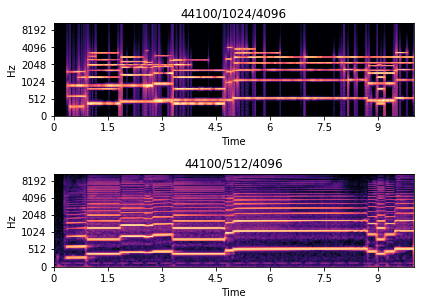

In [44]:
import librosa.display as _display
#from presets import Preset


#librosa = Preset(_librosa)

M = librosa.feature.melspectrogram(y=np.array(y_composition))

# Of course, you can still override the new default manually, e.g.:

M_highres = librosa.feature.melspectrogram(y=y_keep, hop_length=512)


# And plot the results
plt.figure(figsize=(6, 6))
ax = plt.subplot(3, 1, 1)

librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.title('44100/1024/4096')

plt.subplot(3, 1, 2, sharex=ax, sharey=ax)
librosa.display.specshow(librosa.power_to_db(M_highres, ref=np.max),
                         hop_length=512,
                         y_axis='mel', x_axis='time')
plt.title('44100/512/4096')

# We can repeat the whole process with different defaults, just by
# updating the parameter entries
#librosa['sr'] = 11025


plt.tight_layout()
plt.show()
